In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib.colors import ListedColormap

sns.set(style="whitegrid")

%matplotlib inline

# Clean Fool
I copy pasted it into Excel and it formated it into a table!
This cleans it and saves it as `20-06-20_cleaned_fool.csv`

In [2]:
'''
test_fool = pd.read_csv('20-06-20_unclean_fool.csv')
test_fool2 = test_fool[test_fool.index % 2 != 1]
test_fool2 = test_fool2.reset_index()
ticker = test_fool[test_fool.index % 2 != 0]['Unnamed: 1'].reset_index()
test_fool2['TICKER'] = ticker['Unnamed: 1']

test_fool3 = test_fool2[['TICKER', 'REC DATE', 'TEAM', 'RISK', 'ADJ REC PRICE', 'RETURN', 'S&P RETURN']]

test_fool3['TICKER'] = test_fool3['TICKER'].str.replace('New!', '').str.replace('Now', '').str.replace('Starter', '').str.strip()
test_fool3['RETURN'] = test_fool3['RETURN'].str.rstrip('%').astype('float') / 100.0
test_fool3['S&P RETURN'] = test_fool3['S&P RETURN'].str.rstrip('%').astype('float') / 100.0
test_fool3['ADJ REC PRICE'] = pd.to_numeric(test_fool3['ADJ REC PRICE'].str.replace('$', '').str.replace(',', ''), 'coerce')
test_fool3
'''

"\ntest_fool = pd.read_csv('20-06-20_unclean_fool.csv')\ntest_fool2 = test_fool[test_fool.index % 2 != 1]\ntest_fool2 = test_fool2.reset_index()\nticker = test_fool[test_fool.index % 2 != 0]['Unnamed: 1'].reset_index()\ntest_fool2['TICKER'] = ticker['Unnamed: 1']\n\ntest_fool3 = test_fool2[['TICKER', 'REC DATE', 'TEAM', 'RISK', 'ADJ REC PRICE', 'RETURN', 'S&P RETURN']]\n\ntest_fool3['TICKER'] = test_fool3['TICKER'].str.replace('New!', '').str.replace('Now', '').str.replace('Starter', '').str.strip()\ntest_fool3['RETURN'] = test_fool3['RETURN'].str.rstrip('%').astype('float') / 100.0\ntest_fool3['S&P RETURN'] = test_fool3['S&P RETURN'].str.rstrip('%').astype('float') / 100.0\ntest_fool3['ADJ REC PRICE'] = pd.to_numeric(test_fool3['ADJ REC PRICE'].str.replace('$', '').str.replace(',', ''), 'coerce')\ntest_fool3\n"

In [3]:
'''
test_fool3.to_csv('20-06-20_cleaned_fool_with_price.csv')
'''

"\ntest_fool3.to_csv('20-06-20_cleaned_fool_with_price.csv')\n"

# Question 0: How do they calculate their performance?
They claim average of 438% gain while S&P gained 92%.

David achieved 671% and Tom achieved 203%

In [7]:
fool = pd.read_csv('20-06-20_cleaned_fool.csv', index_col=0)
fool['REC DATE'] = pd.to_datetime(fool['REC DATE'])
fool

,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN
0,WEX,2020-06-18,David,15.0,171.53,0.007,-0.006
1,CRWD,2020-06-04,Tom,NaN,95.98,0.053,-0.004
2,GMED,2020-05-21,David,8.0,54.59,-0.110,0.052
3,NOW,2020-05-07,Tom,NaN,381.83,0.047,0.078
4,ZM,2020-04-16,David,8.0,150.26,0.620,0.111
...,...,...,...,...,...,...,...
236,AMZN,2002-09-06,David,8.0,15.31,173.723,3.981
237,ATVI,2002-08-09,David,10.0,16.77,23.564,3.907
238,DIS,2002-06-07,David,9.0,7.35,62.288,3.351
239,EBAY PYPL,2002-05-10,David,9.0,NaN,11.394,3.244


Let's check the average for S&P 500.

In [8]:
f"{fool['S&P RETURN'].mean() * 100:.2f}%"

'118.65%'

That's higher than 92%. Let's look at David and Tom.

In [9]:
david = fool[fool['TEAM'] == 'David']
tom = fool[fool['TEAM'] == 'Tom']
print(f"David: {david['RETURN'].mean() * 100:.2f}%")
print(f"Tom: {tom['RETURN'].mean() * 100:.2f}%")

David: 1087.03%
Tom: 381.50%


In [15]:
len(fool)

241

That's much higher than the reported David 671% and Tom 203%. They do say they incude stocks they sold though, so that can decrease the percentage.

Would trading by Moving Average 3xQQQ have a higher percentage?

In [49]:
def pct_dif(start, end):
    return (end - start) / start * 100
def create_index(data, pct_change, start=0, end=None, has_hold=None):
    if end == None:
        end = len(data)
    arr = np.zeros(len(data))
    arr[:] = np.nan
    arr[start] = data.loc[start, 'QQQ']
    for i in range(start + 1, end):
        if has_hold != None:
            if data.loc[i, 'hold']:
                arr[i] = arr[i - 1] * (1 + data.loc[i, pct_change])
            else:
                arr[i] = arr[i - 1]
        else:
            arr[i] = arr[i - 1] * (1 + data.loc[i, pct_change])
    return arr

def moving_avg(data, start=182):
    arr = np.zeros(len(data))
    arr[:] = np.nan
    # i starts at 188
    for i in range(start - 1, len(data)):
        arr[i] = np.mean(data.loc[i - start + 1:i, '3xQQQ'])
    return arr

def reformat_date(date):
    year, month, day = date.split('-')
    return f"{month.lstrip('0')}/{day.lstrip('0')}/{year[2:]}"

qqq = pd.read_csv('20-06-20_qqq.csv')
qqq = qqq[['Date', 'Close']] \
    .set_index('Date') \
    .rename(columns={'Close': 'QQQ'})
qqq = qqq.reset_index()
qqq['QQQ Pct Change'] = qqq['QQQ'].pct_change()
qqq['3xQQQ Pct Change'] = qqq['QQQ Pct Change'] * 3
qqq['3xQQQ'] = create_index(qqq, '3xQQQ Pct Change')
# takes a while. It's a convolution.
qqq['182 Day Moving Average'] = moving_avg(qqq)
qqq['hold'] = ~(qqq['182 Day Moving Average'] > qqq['3xQQQ'] * 1.02).shift(periods=1, fill_value=False)
qqq['3xQQQ Hold 182 Day Moving Average'] = create_index(qqq, '3xQQQ Pct Change', has_hold=True)
qqq['Date'] = qqq['Date'].apply(reformat_date)
qqq

,Date,QQQ,QQQ Pct Change,3xQQQ Pct Change,3xQQQ,182 Day Moving Average,hold,3xQQQ Hold 182 Day Moving Average
0,3/10/99,51.062500,NaN,NaN,51.062500,NaN,True,51.062500
1,3/11/99,51.312500,0.004896,0.014688,51.812500,NaN,True,51.812500
2,3/12/99,50.062500,-0.024361,-0.073082,48.025959,NaN,True,48.025959
3,3/15/99,51.500000,0.028714,0.086142,52.163027,NaN,True,52.163027
4,3/16/99,51.937500,0.008495,0.025485,53.492424,NaN,True,53.492424
...,...,...,...,...,...,...,...,...
5351,6/15/20,238.750000,0.012167,0.036502,33.972991,28.785555,True,3155.369802
5352,6/16/20,242.850006,0.017173,0.051518,35.723225,28.852483,True,3317.929406
5353,6/17/20,243.619995,0.003171,0.009512,36.063021,28.922708,True,3349.489246
5354,6/18/20,244.279999,0.002709,0.008127,36.356122,28.999305,True,3376.712089


In [50]:
fool2 = pd.read_csv('20-06-20_cleaned_fool.csv', index_col=0)
moving_avg_strat_return = np.zeros(len(fool2))
final_val = qqq.loc[len(qqq) - 1]['3xQQQ Hold 182 Day Moving Average']


for i, date in enumerate(fool2['REC DATE']):
    index = np.where(qqq['Date'].values == str(date))[0][0]
    val = qqq.loc[index]['3xQQQ Hold 182 Day Moving Average']
    moving_avg_strat_return[i] = (final_val - val) / val

f"{moving_avg_strat_return.mean() * 100:.2f}%"

'526.50%'

My strategy actually has a worse performance!

In [51]:
fool_with_my_strat = fool.copy()
fool_with_my_strat['MY STRAT RETURN'] = moving_avg_strat_return
fool_with_my_strat

,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN,MY STRAT RETURN
0,WEX,2020-06-18,David,15.0,171.53,0.007,-0.006,-0.000491
1,CRWD,2020-06-04,Tom,NaN,95.98,0.053,-0.004,0.109000
2,GMED,2020-05-21,David,8.0,54.59,-0.110,0.052,0.199609
3,NOW,2020-05-07,Tom,NaN,381.83,0.047,0.078,0.267062
4,ZM,2020-04-16,David,8.0,150.26,0.620,0.111,0.267062
...,...,...,...,...,...,...,...,...
236,AMZN,2002-09-06,David,8.0,15.31,173.723,3.981,27.083432
237,ATVI,2002-08-09,David,10.0,16.77,23.564,3.907,27.083432
238,DIS,2002-06-07,David,9.0,7.35,62.288,3.351,27.083432
239,EBAY PYPL,2002-05-10,David,9.0,NaN,11.394,3.244,27.083432


In [52]:
fool_with_my_strat.head(20)

,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN,MY STRAT RETURN
0,WEX,2020-06-18,David,15.0,171.53,0.007,-0.006,-0.000491
1,CRWD,2020-06-04,Tom,NaN,95.98,0.053,-0.004,0.109000
2,GMED,2020-05-21,David,8.0,54.59,-0.110,0.052,0.199609
3,NOW,2020-05-07,Tom,NaN,381.83,0.047,0.078,0.267062
4,ZM,2020-04-16,David,8.0,150.26,0.620,0.111,0.267062
5,SHOP,2020-04-02,Tom,NaN,346.30,1.544,0.231,0.267062
6,ZM,2020-03-19,David,8.0,123.77,0.967,0.292,0.267062
7,LK Hold,2020-03-05,Tom,NaN,41.14,-0.907,0.031,-0.047754
8,DXCM,2020-02-20,David,9.0,302.51,0.353,-0.075,-0.327188
9,NVTA,2020-02-06,Tom,NaN,22.16,-0.156,-0.066,-0.287075


In [53]:
fool_with_my_strat.tail(20)

,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN,MY STRAT RETURN
221,NFLX,2004-12-17,David,11.0,1.85,243.687,2.580,11.545517
222,NFLX,2004-10-01,David,11.0,2.33,193.491,2.794,13.326844
223,DIS,2004-08-20,David,9.0,29.58,14.724,2.915,13.326844
224,WB SINA,2004-07-16,David,12.0,NaN,0.596,2.912,13.326844
225,UNH,2004-05-21,Tom,NaN,26.85,9.846,2.949,13.275530
226,BKNG,2004-05-21,David,9.0,23.71,67.617,2.949,13.275530
227,BAMXF,2004-04-16,David,14.0,42.30,0.513,2.814,12.660450
228,DIS,2003-07-11,David,9.0,57.27,8.507,3.392,16.296966
229,HAS,2003-04-11,David,12.0,9.62,6.416,4.070,31.193924
230,DIS,2003-03-07,David,9.0,44.86,11.137,4.320,27.083432


The reason looks to be Netflix is OP. 24300% return. Compared to our largest at 2700% return.

What if you invested $1000 each time for each strategy?

In [54]:
print(f"David: ${1000 * (len(david['RETURN']) + david['RETURN'].sum()):.0f}")
print(f"Tom: ${1000 * (len(tom['RETURN']) + tom['RETURN'].sum()):.0f}")
print(f"S&P: ${500 * (len(fool_with_my_strat['S&P RETURN']) + fool_with_my_strat['S&P RETURN'].sum()):.0f}")
print(f"MY STRAT: ${500 * (len(fool_with_my_strat['MY STRAT RETURN']) + fool_with_my_strat['MY STRAT RETURN'].sum()):.0f}")


David: $1602496
Tom: $510392
S&P: $263469
MY STRAT: $754930


In [22]:
263469/120500

2.1864647302904565

David is really good and Netflix is OP. Your \\$135,000 would have turned into \\$1,602,496

# Question 1: David Gardner vs Tom Gardner?

We've seen David has been more successful. How much of that is due to Netflix?

In [55]:
david.sort_values(by=['RETURN'], ascending=False).head(10)

,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN
221,NFLX,2004-12-17,David,11.0,1.85,243.687,2.580
222,NFLX,2004-10-01,David,11.0,2.33,193.491,2.794
236,AMZN,2002-09-06,David,8.0,15.31,173.723,3.981
213,NFLX,2006-09-15,David,11.0,3.25,138.790,2.136
215,NFLX,2006-06-16,David,11.0,3.87,116.111,2.323
226,BKNG,2004-05-21,David,9.0,23.71,67.617,2.949
238,DIS,2002-06-07,David,9.0,7.35,62.288,3.351
218,NVDA,2005-04-15,David,5.0,6.55,55.580,2.721
231,ATVI,2003-02-07,David,10.0,8.61,46.839,4.325
235,DIS,2002-11-08,David,9.0,11.81,38.394,3.961


His most successful are 4 Netflix and 1 Amazon.

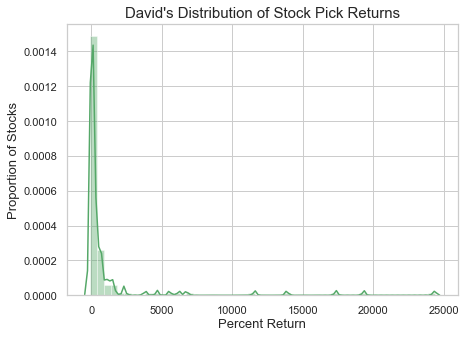

In [56]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.distplot((david['RETURN']) * 100, kde=True, ax=ax, color='g')

ax.set_xlabel('Percent Return', fontsize=13)
ax.set_ylabel('Proportion of Stocks', fontsize=13)
ax.set_title('David\'s Distribution of Stock Pick Returns', fontsize=15);

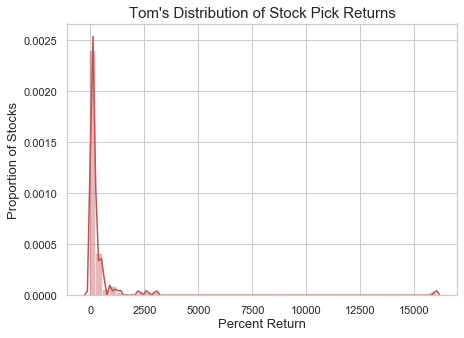

In [57]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.distplot((tom['RETURN']) * 100, kde=True, ax=ax, color='r')

ax.set_xlabel('Percent Return', fontsize=13)
ax.set_ylabel('Proportion of Stocks', fontsize=13)
ax.set_title('Tom\'s Distribution of Stock Pick Returns', fontsize=15);

It really is driven by outliers for both of them. How would they both fair without Netflix?

In [58]:
david_no_nflx = david[david['TICKER'] != 'NFLX']
tom_no_nflx = tom[tom['TICKER'] != 'NFLX']

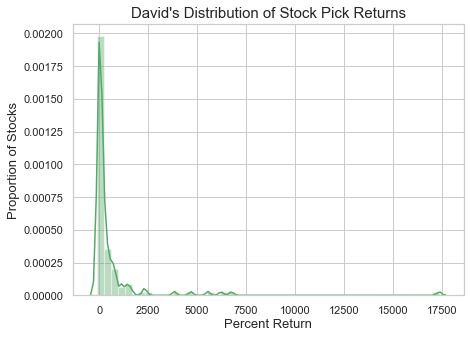

In [59]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.distplot((david_no_nflx['RETURN']) * 100, kde=True, ax=ax, color='g')

ax.set_xlabel('Percent Return', fontsize=13)
ax.set_ylabel('Proportion of Stocks', fontsize=13)
ax.set_title('David\'s Distribution of Stock Pick Returns', fontsize=15);

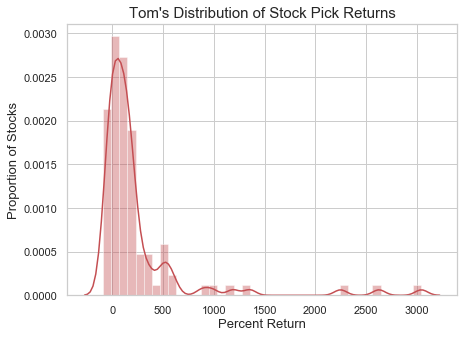

In [60]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.distplot((tom_no_nflx['RETURN']) * 100, kde=True, ax=ax, color='r')

ax.set_xlabel('Percent Return', fontsize=13)
ax.set_ylabel('Proportion of Stocks', fontsize=13)
ax.set_title('Tom\'s Distribution of Stock Pick Returns', fontsize=15);

For David, Amazon was still such a successful outlier. It's a really good idea to swing for the fence.

In [61]:
print(f"David: {david_no_nflx['RETURN'].mean() * 100:.2f}%")
print(f"Tom: {tom_no_nflx['RETURN'].mean() * 100:.2f}%")
print(f"David: ${2000 * (len(david_no_nflx['RETURN']) + david_no_nflx['RETURN'].sum()):.0f}")
print(f"Tom: ${2000 * (len(tom_no_nflx['RETURN']) + tom_no_nflx['RETURN'].sum()):.0f}")

David: 590.17%
Tom: 232.62%
David: $1780636
Tom: $698508


Netflix eventually makes up about half of David's portfolio!

In [62]:
david_with_nflx = david[david['TICKER'] == 'NFLX']
david_with_nflx

,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN
14,NFLX,2019-11-21,David,11.0,311.69,0.456,0.010
148,NFLX,2013-06-21,David,11.0,30.99,13.643,1.246
213,NFLX,2006-09-15,David,11.0,3.25,138.790,2.136
215,NFLX,2006-06-16,David,11.0,3.87,116.111,2.323
221,NFLX,2004-12-17,David,11.0,1.85,243.687,2.580
222,NFLX,2004-10-01,David,11.0,2.33,193.491,2.794


In [63]:
print(f"David, only Netflix: {david_with_nflx['RETURN'].mean() * 100:.2f}%")
print(f"David, only Netflix: ${2000 * (len(david_with_nflx['RETURN']) + david_no_nflx['RETURN'].sum()):.0f}")

David, only Netflix: 11769.63%
David, only Netflix: $1534636


Your \\$6000 would turn into \\$1,534,636.

In [64]:
david_portfolio_return = {}

for ticker, return_amt in david[['TICKER', 'RETURN']].values:
    david_portfolio_return[ticker] = 1000 * (1 + return_amt) + david_portfolio_return.get(ticker, 0)

david_portfolio_return = {k: v for k, v in sorted(david_portfolio_return.items(), key=lambda item: item[1], reverse=True)}
david_portfolio_return

{'NFLX': 712178.0,
 'AMZN': 191297.99999999994,
 'DIS': 147565.0,
 'NVDA': 84123.0,
 'ATVI': 81289.0,
 'BKNG': 77043.0,
 'AAPL': 42489.0,
 'MTCH': 15200.000000000002,
 'ADBE': 13033.0,
 'CGNX': 12611.0,
 'EBAY\xa0PYPL': 12394.0,
 'OKTA': 11514.0,
 'ILMN': 11005.0,
 'HAS': 10696.0,
 'SBUX': 9177.0,
 'SAM': 9106.0,
 'TDG': 6910.0,
 'DASTY': 6426.0,
 'PEGA': 5497.0,
 'INTU': 5212.0,
 'GILD': 5211.0,
 'IDXX': 4795.0,
 'CNI': 4544.000000000001,
 'MTN': 4127.0,
 'FDX': 4010.0,
 'MCK': 3845.0,
 'TXRH': 3839.0,
 'ZM': 3587.0,
 'FTNT': 3458.0,
 'MASI': 3396.0,
 'NYT': 3254.0,
 'ZNGA': 3183.0,
 'WB\xa0SINA': 3176.0,
 'ODFL': 2972.0,
 'MKC': 2832.0,
 'RH': 2668.0,
 'NDAQ': 2564.0,
 'FICO': 2534.0,
 'TMUS': 2407.0,
 'GLW': 2325.0,
 'CMI': 2230.0,
 'KMX': 2205.0,
 'STMP': 2152.0,
 'CBOE': 2152.0,
 'IIVI': 2123.0,
 'CASY': 1866.0,
 'TSCO': 1865.0,
 'RPM': 1853.0,
 'LFUS': 1827.0,
 'ECL': 1760.0,
 'SEDG': 1718.0,
 'NTDOY': 1685.0,
 'BAMXF': 1513.0,
 'SNPS': 1498.0,
 'ZBRA': 1478.0,
 'JD': 1461.0,
 'C

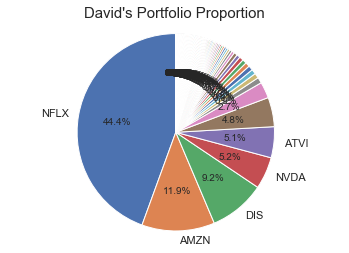

In [65]:
labels = list(david_portfolio_return.keys())[:5] + ['' for _ in list(david_portfolio_return.keys())[5:]]
sizes = david_portfolio_return.values()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.set_title('David\'s Portfolio Proportion', fontsize=15);

plt.show()

In [66]:
print('David\'s Portfolio Value: $' + str(sum(david_portfolio_return.values())))

David's Portfolio Value: $1602496.0


In [67]:
tom_portfolio_return = {}

for ticker, return_amt in tom[['TICKER', 'RETURN']].values:
    tom_portfolio_return[ticker] = 1000 * (1 + return_amt) + tom_portfolio_return.get(ticker, 0)

tom_portfolio_return = {k: v for k, v in sorted(tom_portfolio_return.items(), key=lambda item: item[1], reverse=True)}
tom_portfolio_return

{'NFLX': 161138.0,
 'SHOP': 43269.0,
 'UNH': 34318.0,
 'TSLA': 33761.0,
 'SHW': 15940.0,
 'MA': 15790.0,
 'CTAS': 14544.0,
 'COST': 9850.0,
 'TTD': 8253.0,
 'NKE': 8229.0,
 'PAYC': 8076.0,
 'HEI': 7069.0,
 'CMG': 6944.0,
 'BRK.B': 6843.0,
 'BWA': 6801.000000000002,
 'NATI': 6355.0,
 'ZM': 5861.0,
 'WSM': 5553.0,
 'IBKR': 5286.0,
 'FB': 4922.0,
 'GOOG\xa0GOOGL': 4685.000000000001,
 'TWLO': 4409.0,
 'SAFT': 4397.0,
 'AFL': 4343.0,
 'WIX': 4281.0,
 'WSO': 4226.000000000001,
 'BKNG': 4044.0,
 'APPN': 3996.0,
 'SLAB': 3450.0,
 'MKL': 3310.0,
 'ULTA': 2814.0,
 'ZS': 2787.0,
 'WDAY': 2549.0000000000005,
 'MAR': 2379.0,
 'ROP': 2312.0,
 'IT': 2304.0000000000005,
 'MTH': 2270.0,
 'SIVB': 2250.0,
 'BCPC': 2110.0000000000005,
 'XPO': 2108.0,
 'DISCK': 2106.0,
 'RHI': 2078.9999999999995,
 'GOOG': 2043.0000000000002,
 'ANET': 2034.0,
 'ROL': 1923.0,
 'TNC': 1897.0,
 'VRNS': 1553.9999999999998,
 'SBUX': 1512.0,
 'WAB': 1501.0,
 'JEF\xa0SPB': 1456.9999999999998,
 'HUBS': 1433.0,
 'SFIX': 1373.0,
 'CT

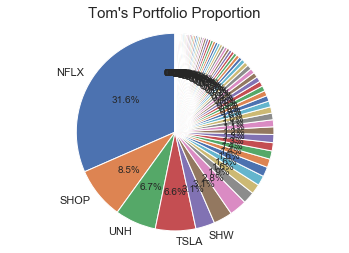

In [68]:
labels = list(tom_portfolio_return.keys())[:5] + ['' for _ in list(tom_portfolio_return.keys())[5:]]
sizes = tom_portfolio_return.values()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.set_title('Tom\'s Portfolio Proportion', fontsize=15);

plt.show()

In [69]:
print('Tom\'s Portfolio Value: $' + str(sum(tom_portfolio_return.values())))

Tom's Portfolio Value: $510392.0


In [72]:
david_portfolio_return = {}

for ticker, return_amt in david[david['REC DATE'] > datetime.datetime.strptime("01/01/10", "%m/%d/%y")][['TICKER', 'RETURN']].values:
    david_portfolio_return[ticker] = 1000 * (1 + return_amt) + david_portfolio_return.get(ticker, 0)

david_portfolio_return = {k: v for k, v in sorted(david_portfolio_return.items(), key=lambda item: item[1], reverse=True)}
david_portfolio_return

{'AMZN': 16575.0,
 'NFLX': 16099.0,
 'MTCH': 15200.000000000002,
 'CGNX': 12611.0,
 'OKTA': 11514.0,
 'SAM': 9106.0,
 'AAPL': 8830.0,
 'BKNG': 8426.0,
 'TDG': 6910.0,
 'PEGA': 5497.0,
 'INTU': 5212.0,
 'GILD': 5211.0,
 'IDXX': 4795.0,
 'SBUX': 4130.0,
 'MTN': 4127.0,
 'ATVI': 3952.0,
 'TXRH': 3839.0,
 'NVDA': 3603.0,
 'ZM': 3587.0,
 'FTNT': 3458.0,
 'MASI': 3396.0,
 'NYT': 3254.0,
 'ZNGA': 3183.0,
 'ODFL': 2972.0,
 'MKC': 2832.0,
 'RH': 2668.0,
 'NDAQ': 2564.0,
 'FICO': 2534.0,
 'ILMN': 2453.9999999999995,
 'TMUS': 2407.0,
 'GLW': 2325.0,
 'CMI': 2230.0,
 'KMX': 2205.0,
 'STMP': 2152.0,
 'CBOE': 2152.0,
 'IIVI': 2123.0,
 'CASY': 1866.0,
 'TSCO': 1865.0,
 'RPM': 1853.0,
 'LFUS': 1827.0,
 'ECL': 1760.0,
 'SEDG': 1718.0,
 'NTDOY': 1685.0,
 'SNPS': 1498.0,
 'ZBRA': 1478.0,
 'JD': 1461.0,
 'CRUS': 1452.0,
 'LKQ': 1435.0,
 'CME': 1376.0,
 'AMGN': 1359.0,
 'DXCM': 1353.0,
 'BDX': 1349.0,
 'NBIX': 1330.0,
 'DAR': 1321.0,
 'NVO': 1320.0,
 'JKHY': 1291.0,
 'CRI': 1254.0,
 'HCA': 1237.0,
 'DISCK'

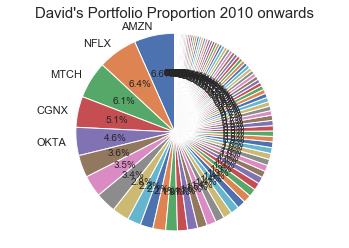

In [73]:
labels = list(david_portfolio_return.keys())[:5] + ['' for _ in list(david_portfolio_return.keys())[5:]]
sizes = david_portfolio_return.values()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.set_title('David\'s Portfolio Proportion 2010 onwards', fontsize=15);

plt.show()

In [74]:
print('David\'s 2010 Onwards Portfolio Value: $' + str(sum(david_portfolio_return.values())))

David's 2010 Onwards Portfolio Value: $249674.0


In [75]:
tom_portfolio_return = {}

for ticker, return_amt in tom[tom['REC DATE'] > datetime.datetime.strptime("01/01/10", "%m/%d/%y")][['TICKER', 'RETURN']].values:
    tom_portfolio_return[ticker] = 1000 * (1 + return_amt) + tom_portfolio_return.get(ticker, 0)

tom_portfolio_return = {k: v for k, v in sorted(tom_portfolio_return.items(), key=lambda item: item[1], reverse=True)}
tom_portfolio_return

{'SHOP': 43269.0,
 'TSLA': 33761.0,
 'MA': 15790.0,
 'TTD': 8253.0,
 'NKE': 8229.0,
 'PAYC': 8076.0,
 'HEI': 7069.0,
 'CMG': 6944.0,
 'ZM': 5861.0,
 'WSM': 5553.0,
 'FB': 4922.0,
 'GOOG\xa0GOOGL': 4685.000000000001,
 'TWLO': 4409.0,
 'WIX': 4281.0,
 'WSO': 4226.000000000001,
 'BKNG': 4044.0,
 'APPN': 3996.0,
 'MKL': 3310.0,
 'SHW': 3042.0,
 'ULTA': 2814.0,
 'ZS': 2787.0,
 'WDAY': 2549.0000000000005,
 'MAR': 2379.0,
 'ROP': 2312.0,
 'IT': 2304.0000000000005,
 'SIVB': 2250.0,
 'BCPC': 2110.0000000000005,
 'XPO': 2108.0,
 'DISCK': 2106.0,
 'RHI': 2078.9999999999995,
 'GOOG': 2043.0000000000002,
 'ANET': 2034.0,
 'ROL': 1923.0,
 'TNC': 1897.0,
 'VRNS': 1553.9999999999998,
 'SBUX': 1512.0,
 'IBKR': 1504.0,
 'WAB': 1501.0,
 'JEF\xa0SPB': 1456.9999999999998,
 'HUBS': 1433.0,
 'SFIX': 1373.0,
 'BRK.B': 1267.0,
 'CTSH': 1249.0,
 'KMI': 1218.0,
 'LOPE': 1194.0,
 'OLLI': 1164.0,
 'WORK': 1104.0,
 'CRWD': 1053.0,
 'NOW': 1047.0,
 'SQ': 1037.0,
 'HQY': 920.0,
 'IRBT': 920.0,
 'BWA': 855.0,
 'NVTA':

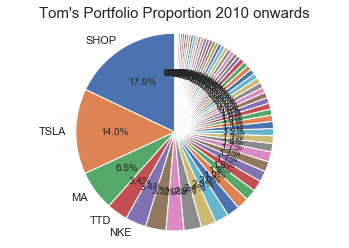

In [76]:
labels = list(tom_portfolio_return.keys())[:5] + ['' for _ in list(tom_portfolio_return.keys())[5:]]
sizes = tom_portfolio_return.values()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.set_title('Tom\'s Portfolio Proportion 2010 onwards', fontsize=15);

plt.show()

In [77]:
print('Tom\'s 2010 Onwards Portfolio Value: $' + str(sum(tom_portfolio_return.values())))

Tom's 2010 Onwards Portfolio Value: $241525.0


In [78]:
david_portfolio_return = {}

for ticker, return_amt in david[david['REC DATE'] > datetime.datetime.strptime("01/01/15", "%m/%d/%y")][['TICKER', 'RETURN']].values:
    david_portfolio_return[ticker] = 1000 * (1 + return_amt) + david_portfolio_return.get(ticker, 0)

david_portfolio_return = {k: v for k, v in sorted(david_portfolio_return.items(), key=lambda item: item[1], reverse=True)}
david_portfolio_return

{'MTCH': 15200.000000000002,
 'OKTA': 11514.0,
 'NVDA': 3603.0,
 'ZM': 3587.0,
 'FTNT': 3458.0,
 'MASI': 3396.0,
 'NYT': 3254.0,
 'ZNGA': 3183.0,
 'ODFL': 2972.0,
 'RH': 2668.0,
 'NDAQ': 2564.0,
 'FICO': 2534.0,
 'ILMN': 2453.9999999999995,
 'TMUS': 2407.0,
 'STMP': 2152.0,
 'CASY': 1866.0,
 'TSCO': 1865.0,
 'RPM': 1853.0,
 'ECL': 1760.0,
 'SEDG': 1718.0,
 'NTDOY': 1685.0,
 'TXRH': 1547.0000000000002,
 'AMZN': 1511.0000000000002,
 'SNPS': 1498.0,
 'ZBRA': 1478.0,
 'JD': 1461.0,
 'NFLX': 1456.0,
 'CRUS': 1452.0,
 'CME': 1376.0,
 'AMGN': 1359.0,
 'DXCM': 1353.0,
 'BDX': 1349.0,
 'NBIX': 1330.0,
 'NVO': 1320.0,
 'JKHY': 1291.0,
 'CGNX': 1253.0,
 'HCA': 1237.0,
 'NICE': 1106.0,
 'UNP': 1064.0,
 'WEX': 1006.9999999999999,
 'ACN': 976.0,
 'UHAL': 950.0,
 'HRC': 927.0,
 'WM': 893.0,
 'MTN': 892.0,
 'GMED': 890.0,
 'TLK': 880.0,
 'PAC': 811.0,
 'MMM': 806.0,
 'NEWR': 774.0,
 'TXT': 731.0,
 'ALK': 586.0000000000001,
 'JBLU': 550.0,
 'BB': 490.0,
 'HA': 478.0,
 'BUD': 447.00000000000006,
 'ALKS'

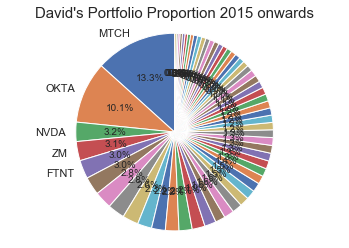

In [79]:
labels = list(david_portfolio_return.keys())[:5] + ['' for _ in list(david_portfolio_return.keys())[5:]]
sizes = david_portfolio_return.values()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.set_title('David\'s Portfolio Proportion 2015 onwards', fontsize=15);

plt.show()

In [80]:
print('David\'s 2010 Onwards Portfolio Value: $' + str(sum(david_portfolio_return.values())))

David's 2010 Onwards Portfolio Value: $114226.0


In [81]:
tom_portfolio_return = {}

for ticker, return_amt in tom[tom['REC DATE'] > datetime.datetime.strptime("01/01/15", "%m/%d/%y")][['TICKER', 'RETURN']].values:
    tom_portfolio_return[ticker] = 1000 * (1 + return_amt) + tom_portfolio_return.get(ticker, 0)

tom_portfolio_return = {k: v for k, v in sorted(tom_portfolio_return.items(), key=lambda item: item[1], reverse=True)}
tom_portfolio_return

{'SHOP': 43269.0,
 'TTD': 8253.0,
 'PAYC': 8076.0,
 'ZM': 5861.0,
 'FB': 4922.0,
 'MA': 4448.0,
 'TWLO': 4409.0,
 'WIX': 4281.0,
 'APPN': 3996.0,
 'CMG': 3727.0,
 'ZS': 2787.0,
 'WDAY': 2549.0000000000005,
 'MAR': 2379.0,
 'TSLA': 2325.9999999999995,
 'ROP': 2312.0,
 'SIVB': 2250.0,
 'XPO': 2108.0,
 'GOOG': 2043.0000000000002,
 'ANET': 2034.0,
 'NKE': 1933.0,
 'ROL': 1923.0,
 'MKL': 1871.0,
 'VRNS': 1553.9999999999998,
 'SBUX': 1512.0,
 'HUBS': 1433.0,
 'SFIX': 1373.0,
 'BRK.B': 1267.0,
 'KMI': 1218.0,
 'LOPE': 1194.0,
 'OLLI': 1164.0,
 'WORK': 1104.0,
 'CRWD': 1053.0,
 'NOW': 1047.0,
 'SQ': 1037.0,
 'HQY': 920.0,
 'IRBT': 920.0,
 'BWA': 855.0,
 'NVTA': 844.0,
 'TLND': 837.0,
 'JEF\xa0SPB': 798.9999999999999,
 'WAL': 764.0,
 'AMG': 442.99999999999994,
 'CRTO\xa0Hold': 414.00000000000006,
 'CWBHF': 226.99999999999997,
 'LK\xa0Hold': 92.99999999999997}

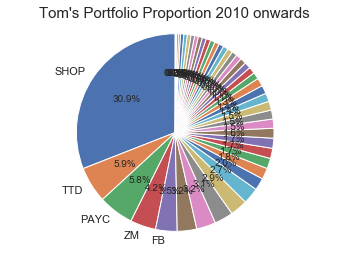

In [82]:
labels = list(tom_portfolio_return.keys())[:5] + ['' for _ in list(tom_portfolio_return.keys())[5:]]
sizes = tom_portfolio_return.values()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax1.set_title('Tom\'s Portfolio Proportion 2010 onwards', fontsize=15);

plt.show()

In [83]:
print('Tom\'s 2015 Onwards Portfolio Value: $' + str(sum(tom_portfolio_return.values())))

Tom's 2015 Onwards Portfolio Value: $139829.0


David does better because of Netflix, but 2015 onwards, Tom does better because of Shopify.

Another thing is to normalize how long the return is.

In [84]:
my_fool = fool.copy()
my_fool['Days to 06/20/20'] = fool['REC DATE'].apply(lambda x: (datetime.datetime.strptime("06/20/20", "%m/%d/%y") - x).days)
my_fool['Return over Days'] = my_fool['RETURN'] / my_fool['Days to 06/20/20']
my_fool

,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN,Days to 06/20/20,Return over Days
0,WEX,2020-06-18,David,15.0,171.53,0.007,-0.006,2,0.003500
1,CRWD,2020-06-04,Tom,NaN,95.98,0.053,-0.004,16,0.003312
2,GMED,2020-05-21,David,8.0,54.59,-0.110,0.052,30,-0.003667
3,NOW,2020-05-07,Tom,NaN,381.83,0.047,0.078,44,0.001068
4,ZM,2020-04-16,David,8.0,150.26,0.620,0.111,65,0.009538
...,...,...,...,...,...,...,...,...,...
236,AMZN,2002-09-06,David,8.0,15.31,173.723,3.981,6497,0.026739
237,ATVI,2002-08-09,David,10.0,16.77,23.564,3.907,6525,0.003611
238,DIS,2002-06-07,David,9.0,7.35,62.288,3.351,6588,0.009455
239,EBAY PYPL,2002-05-10,David,9.0,NaN,11.394,3.244,6616,0.001722


In [85]:
my_fool.sort_values(by='Return over Days', ascending=False).head(15)

,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN,Days to 06/20/20,Return over Days
221,NFLX,2004-12-17,David,11.0,1.85,243.687,2.580,5664,0.043024
222,NFLX,2004-10-01,David,11.0,2.33,193.491,2.794,5741,0.033703
208,NFLX,2007-06-15,Tom,NaN,2.82,160.138,1.662,4754,0.033685
213,NFLX,2006-09-15,David,11.0,3.25,138.790,2.136,5027,0.027609
236,AMZN,2002-09-06,David,8.0,15.31,173.723,3.981,6497,0.026739
215,NFLX,2006-06-16,David,11.0,3.87,116.111,2.323,5118,0.022687
5,SHOP,2020-04-02,Tom,NaN,346.30,1.544,0.231,79,0.019544
94,SHOP,2016-07-15,Tom,NaN,32.32,26.259,0.551,1436,0.018286
226,BKNG,2004-05-21,David,9.0,23.71,67.617,2.949,5874,0.011511
155,TSLA,2012-11-16,Tom,NaN,31.84,30.435,1.665,2773,0.010975


It does seem to be a mix. David is better but it really depends on a few critical stocks. David has done better finding Netflix and Amazon, and more importantly reinvesting in them while Tom has done it with Shopify.

__Lesson 1. Have a slight prefermnce towards David's Picks.__

# Question 2: Buy Your Winners? (Let Your Winners Run, Add to Your Winners)

What if they are at all time highs?

Let's first look at when they re-recommended.

In [86]:
fool.groupby('TICKER').size().sort_values(ascending=False).head(20)

TICKER
NFLX         7
DIS          6
ZM           4
BKNG         4
MA           4
SHOP         4
ATVI         4
AAPL         3
AMZN         3
BRK.B        3
CMG          3
SBUX         3
MKL          3
CGNX         3
NVDA         3
MTN          2
ZNGA         2
ILMN         2
CRTO Hold    2
PAYC         2
dtype: int64

In [87]:
david.groupby('TICKER').size().sort_values(ascending=False).head(25)

TICKER
NFLX       6
DIS        6
ATVI       4
AAPL       3
AMZN       3
NVDA       3
CGNX       3
ZM         2
MTN        2
MTCH       2
FDX        2
ILMN       2
HAS        2
SBUX       2
DDD        2
BKNG       2
OKTA       2
ZNGA       2
TXRH       2
WB SINA    2
SWIR       2
SEDG       1
UHAL       1
CRUS       1
CVS        1
dtype: int64

In [107]:
(my_fool.groupby('TICKER').size()
 / np.log(my_fool.groupby('TICKER')['Days to 06/20/20'].sum())
 * (my_fool.groupby('TICKER').size() > 1).astype(int)
).sort_values(ascending=False).head(20)

TICKER
NFLX     0.681097
ZM       0.601596
DIS      0.572652
SHOP     0.497845
MA       0.451601
BKNG     0.417367
ATVI     0.405634
MKL      0.359477
CMG      0.347331
CGNX     0.340556
SBUX     0.326630
BRK.B    0.324488
AMZN     0.323736
NVDA     0.323578
AAPL     0.318807
ZNGA     0.301092
TWLO     0.289321
WIX      0.283474
TTD      0.282084
SFIX     0.276938
dtype: float64

In [108]:
nflx_fool = fool[fool['TICKER'] == 'NFLX']
nflx_fool

,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN
14,NFLX,2019-11-21,David,11.0,311.69,0.456,0.010
148,NFLX,2013-06-21,David,11.0,30.99,13.643,1.246
208,NFLX,2007-06-15,Tom,NaN,2.82,160.138,1.662
213,NFLX,2006-09-15,David,11.0,3.25,138.790,2.136
215,NFLX,2006-06-16,David,11.0,3.87,116.111,2.323
221,NFLX,2004-12-17,David,11.0,1.85,243.687,2.580
222,NFLX,2004-10-01,David,11.0,2.33,193.491,2.794


In [109]:
company = 'Netflix'

print(f'A $1000 investment in {company}:')

for rec_date, return_amt in nflx_fool[['REC DATE', 'RETURN']].values:
    print(f"  on {str(rec_date).split(' ')[0]} would be ${1000 * (1 + return_amt):.0f}")

A $1000 investment in Netflix:
  on 2019-11-21 would be $1456
  on 2013-06-21 would be $14643
  on 2007-06-15 would be $161138
  on 2006-09-15 would be $139790
  on 2006-06-16 would be $117111
  on 2004-12-17 would be $244687
  on 2004-10-01 would be $194491


For comparison:
* Accenture on 12/19/2019 would be \\$976 instead of \\$1,456
* Texas Roadhouse on 08/16/2013 would be \\$2,292 instead of \\$14,643
* Apple on 01/18/2008 would be \\$17,525 instead of \\$161,138
* FedEx on 12/15/2006 would be \\$1,322 instead of \\$139,790
* NVIDIA on 04/15/2005 would be \\$56,580 instead of \\$244,687

Buying the re-recomendation for Netflix beats all of them.

In [110]:
nflx = pd.read_csv('20-06-20_NFLX.csv')
nflx['Date'] = pd.to_datetime(nflx['Date'])
nflx

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200
...,...,...,...,...,...,...,...
4546,2020-06-15,421.399994,426.489990,415.420013,425.500000,425.500000,4467900
4547,2020-06-16,425.760010,437.959991,425.179993,436.130005,436.130005,5507900
4548,2020-06-17,441.820007,450.459991,439.220001,447.769989,447.769989,6522400
4549,2020-06-18,448.730011,452.760010,442.799988,449.869995,449.869995,4277600


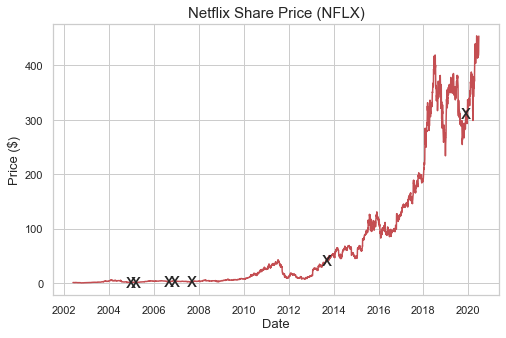

In [111]:
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(x="Date", y="Close", data=nflx, ax=ax, color='r')

ax.text(datetime.datetime.strptime("10/1/04", "%m/%d/%y"), 20, "x",
        horizontalalignment='left', verticalalignment='top', fontsize=20)
ax.text(datetime.datetime.strptime("12/17/04", "%m/%d/%y"), 20, "x",
        horizontalalignment='left', verticalalignment='top', fontsize=20)
ax.text(datetime.datetime.strptime("6/16/06", "%m/%d/%y"), 22, "x",
        horizontalalignment='left', verticalalignment='top', fontsize=20)
ax.text(datetime.datetime.strptime("9/15/06", "%m/%d/%y"), 22, "x",
        horizontalalignment='left', verticalalignment='top', fontsize=20)
ax.text(datetime.datetime.strptime("6/15/07", "%m/%d/%y"), 22, "x",
        horizontalalignment='left', verticalalignment='top', fontsize=20)
ax.text(datetime.datetime.strptime("6/21/13", "%m/%d/%y"), 60, "x",
        horizontalalignment='left', verticalalignment='top', fontsize=20)
ax.text(datetime.datetime.strptime("11/21/19", "%m/%d/%y"), 312, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)


ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Price ($)', fontsize=13)
ax.set_title('Netflix Share Price (NFLX)', fontsize=15);

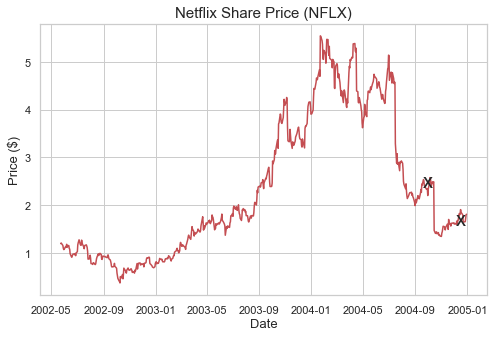

In [112]:
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(x="Date", y="Close", data=nflx[nflx['Date'] < datetime.datetime.strptime("12/31/04", "%m/%d/%y")],
                  ax=ax, color='r')

ax.text(datetime.datetime.strptime("10/1/04", "%m/%d/%y"), 2.5, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("12/17/04", "%m/%d/%y"), 1.7, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Price ($)', fontsize=13)
ax.set_title('Netflix Share Price (NFLX)', fontsize=15);

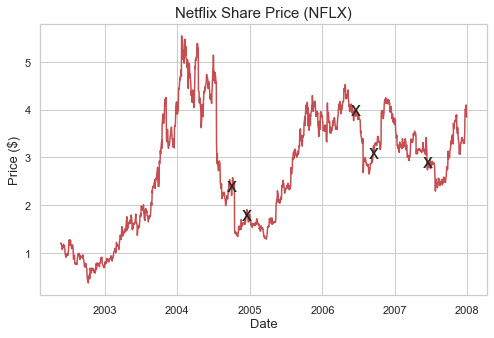

In [113]:
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(x="Date", y="Close", data=nflx[nflx['Date'] < datetime.datetime.strptime("12/31/07", "%m/%d/%y")],
                  ax=ax, color='r')

ax.text(datetime.datetime.strptime("10/1/04", "%m/%d/%y"), 2.4, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("12/17/04", "%m/%d/%y"), 1.8, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("6/16/06", "%m/%d/%y"), 4, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("9/15/06", "%m/%d/%y"), 3.1, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("6/15/07", "%m/%d/%y"), 2.9, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Price ($)', fontsize=13)
ax.set_title('Netflix Share Price (NFLX)', fontsize=15);

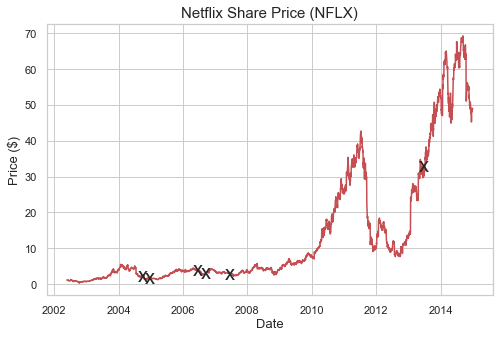

In [114]:
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(x="Date", y="Close", data=nflx[nflx['Date'] < datetime.datetime.strptime("12/31/14", "%m/%d/%y")],
                  ax=ax, color='r')

ax.text(datetime.datetime.strptime("10/1/04", "%m/%d/%y"), 2.5, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("12/17/04", "%m/%d/%y"), 1.7, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("6/16/06", "%m/%d/%y"), 4, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("9/15/06", "%m/%d/%y"), 3.1, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("6/15/07", "%m/%d/%y"), 2.9, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("6/21/13", "%m/%d/%y"), 33, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Price ($)', fontsize=13)
ax.set_title('Netflix Share Price (NFLX)', fontsize=15);

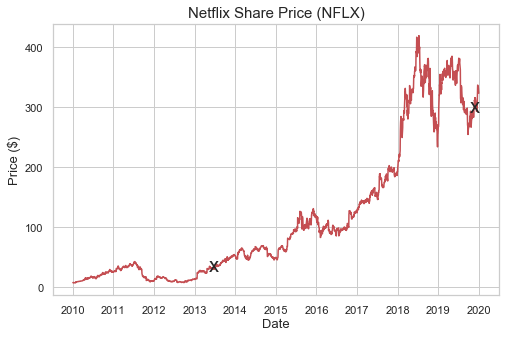

In [115]:
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(x="Date", y="Close", data=nflx[(nflx['Date'] > datetime.datetime.strptime("12/31/09", "%m/%d/%y"))
                                                & (nflx['Date'] < datetime.datetime.strptime("12/31/19", "%m/%d/%y"))],
                  ax=ax, color='r')

ax.text(datetime.datetime.strptime("6/21/13", "%m/%d/%y"), 35, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("11/21/19", "%m/%d/%y"), 300, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Price ($)', fontsize=13)
ax.set_title('Netflix Share Price (NFLX)', fontsize=15);

In [116]:
dis_fool = fool[fool['TICKER'] == 'DIS']
dis_fool

,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN
200,DIS,2008-12-19,David,9.0,61.88,6.515,3.448
223,DIS,2004-08-20,David,9.0,29.58,14.724,2.915
228,DIS,2003-07-11,David,9.0,57.27,8.507,3.392
230,DIS,2003-03-07,David,9.0,44.86,11.137,4.320
235,DIS,2002-11-08,David,9.0,11.81,38.394,3.961
238,DIS,2002-06-07,David,9.0,7.35,62.288,3.351


In [117]:
dis = pd.read_csv('20-06-20_DIS.csv')
dis['Date'] = pd.to_datetime(dis['Date'])
dis

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.092908,0.096026,0.092908,0.092908,0.058360,817400
1,1962-01-03,0.092908,0.094467,0.092908,0.094155,0.059143,778500
2,1962-01-04,0.094155,0.094467,0.093532,0.094155,0.059143,934200
3,1962-01-05,0.094155,0.094779,0.093844,0.094467,0.059339,934200
4,1962-01-08,0.094467,0.095714,0.092285,0.094155,0.059143,1245600
...,...,...,...,...,...,...,...
14713,2020-06-15,112.080002,118.120003,111.709999,117.080002,117.080002,14156400
14714,2020-06-16,121.239998,121.500000,116.050003,118.440002,118.440002,12951200
14715,2020-06-17,118.639999,119.230003,117.139999,117.650002,117.650002,8913100
14716,2020-06-18,116.879997,118.529999,115.930000,118.370003,118.370003,9577300


In [118]:
company = 'Disney'

print(f'A $1000 investment in {company}:')

for rec_date, return_amt in dis_fool[['REC DATE', 'RETURN']].values:
    print(f"  on {str(rec_date).split(' ')[0]} would be ${1000 * (1 + return_amt):.0f}")

A $1000 investment in Disney:
  on 2008-12-19 would be $7515
  on 2004-08-20 would be $15724
  on 2003-07-11 would be $9507
  on 2003-03-07 would be $12137
  on 2002-11-08 would be $39394
  on 2002-06-07 would be $63288


For comparison:
* McKesson on 02/20/2009 would be \\$3,845 instead of \\$7,515
* Netflix on 10/01/2004 would be \\$194,491 instead of \\$15,724
* BMW on 04/16/2004 would be \\$1,513 instead of \\$9,507
* Hasbro on 04/11/2003 would be \\$7,416 instead of \\$12,137
* FedEx on 01/10/2003 would be \\$2,688 instead of \\$39,394
* Activision Blizzard on 06/07/2002 would be \\$63,288 instead of \\$63,288

This shows the power of buying new stocks! We wouldn't have found that 200 bagger Netflix.

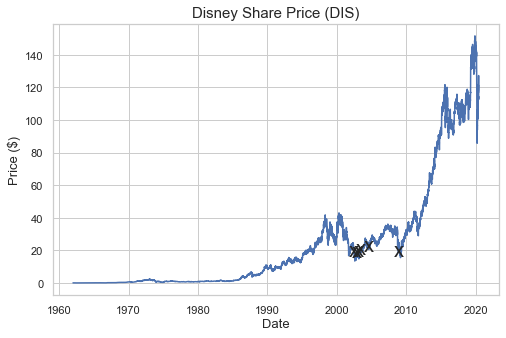

In [119]:
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(x="Date", y="Close", data=dis, ax=ax, color='b')

ax.text(datetime.datetime.strptime("2002-06-07", "%Y-%m-%d"), 20, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2002-11-08", "%Y-%m-%d"), 19, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2003-03-07", "%Y-%m-%d"), 20, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2003-07-11", "%Y-%m-%d"), 21, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2004-08-20", "%Y-%m-%d"), 23, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2008-12-19", "%Y-%m-%d"), 20, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Price ($)', fontsize=13)
ax.set_title('Disney Share Price (DIS)', fontsize=15);

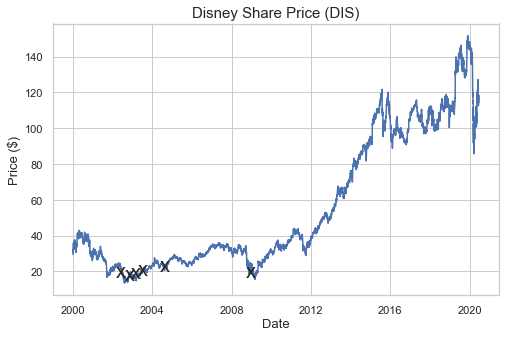

In [120]:
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(x="Date", y="Close", data=dis[dis['Date'] > datetime.datetime.strptime("12/31/99", "%m/%d/%y")], ax=ax, color='b')

ax.text(datetime.datetime.strptime("2002-06-07", "%Y-%m-%d"), 20, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2002-11-08", "%Y-%m-%d"), 18, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2003-03-07", "%Y-%m-%d"), 19, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2003-07-11", "%Y-%m-%d"), 21, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2004-08-20", "%Y-%m-%d"), 23, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2008-12-19", "%Y-%m-%d"), 20, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Price ($)', fontsize=13)
ax.set_title('Disney Share Price (DIS)', fontsize=15);

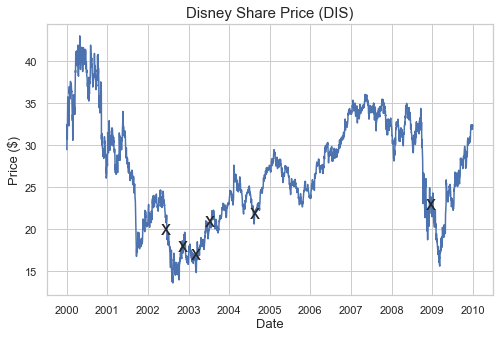

In [121]:
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.lineplot(x="Date", y="Close", data=dis[(dis['Date'] > datetime.datetime.strptime("12/31/99", "%m/%d/%y"))
                                               & (dis['Date'] < datetime.datetime.strptime("12/31/09", "%m/%d/%y"))], ax=ax, color='b')

ax.text(datetime.datetime.strptime("2002-06-07", "%Y-%m-%d"), 20, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2002-11-08", "%Y-%m-%d"), 18, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2003-03-07", "%Y-%m-%d"), 17, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2003-07-11", "%Y-%m-%d"), 21, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2004-08-20", "%Y-%m-%d"), 22, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)
ax.text(datetime.datetime.strptime("2008-12-19", "%Y-%m-%d"), 23, "x",
        horizontalalignment='center', verticalalignment='center', fontsize=20)

ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Price ($)', fontsize=13)
ax.set_title('Disney Share Price (DIS)', fontsize=15);

__Lesson 2. Invest in your winners. Invest in re-recomendations. This holds even at all time highs. Strong companies and strong leader continue to do well.__

# Question 3. What Market Cap relative to largest Market Cap?

Tge hupothesis is you can't have a huge market cap to have room to grow a lot. Let's see how true that is. 

There isn't a good way to do this programaticly so I'll do it manually.

In [123]:
my_fool.sort_values(by='Return over Days', ascending=False).head(15)

,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN,Days to 06/20/20,Return over Days
221,NFLX,2004-12-17,David,11.0,1.85,243.687,2.580,5664,0.043024
222,NFLX,2004-10-01,David,11.0,2.33,193.491,2.794,5741,0.033703
208,NFLX,2007-06-15,Tom,NaN,2.82,160.138,1.662,4754,0.033685
213,NFLX,2006-09-15,David,11.0,3.25,138.790,2.136,5027,0.027609
236,AMZN,2002-09-06,David,8.0,15.31,173.723,3.981,6497,0.026739
215,NFLX,2006-06-16,David,11.0,3.87,116.111,2.323,5118,0.022687
5,SHOP,2020-04-02,Tom,NaN,346.30,1.544,0.231,79,0.019544
94,SHOP,2016-07-15,Tom,NaN,32.32,26.259,0.551,1436,0.018286
226,BKNG,2004-05-21,David,9.0,23.71,67.617,2.949,5874,0.011511
155,TSLA,2012-11-16,Tom,NaN,31.84,30.435,1.665,2773,0.010975


In [124]:
my_fool[(my_fool['REC DATE'] < datetime.datetime.strptime("01/01/10", "%m/%d/%y"))
    ].sort_values(by='Return over Days', ascending=False).head(15)


,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN,Days to 06/20/20,Return over Days
221,NFLX,2004-12-17,David,11.0,1.85,243.687,2.580,5664,0.043024
222,NFLX,2004-10-01,David,11.0,2.33,193.491,2.794,5741,0.033703
208,NFLX,2007-06-15,Tom,NaN,2.82,160.138,1.662,4754,0.033685
213,NFLX,2006-09-15,David,11.0,3.25,138.790,2.136,5027,0.027609
236,AMZN,2002-09-06,David,8.0,15.31,173.723,3.981,6497,0.026739
215,NFLX,2006-06-16,David,11.0,3.87,116.111,2.323,5118,0.022687
226,BKNG,2004-05-21,David,9.0,23.71,67.617,2.949,5874,0.011511
218,NVDA,2005-04-15,David,5.0,6.55,55.580,2.721,5545,0.010023
238,DIS,2002-06-07,David,9.0,7.35,62.288,3.351,6588,0.009455
231,ATVI,2003-02-07,David,10.0,8.61,46.839,4.325,6343,0.007384


In [125]:
my_fool[(my_fool['REC DATE'] > datetime.datetime.strptime("01/01/10", "%m/%d/%y"))
     & (my_fool['REC DATE'] < datetime.datetime.strptime("01/01/15", "%m/%d/%y"))
    ].sort_values(by='Return over Days', ascending=False).head(15)


,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN,Days to 06/20/20,Return over Days
155,TSLA,2012-11-16,Tom,NaN,31.84,30.435,1.665,2773,0.010975
148,NFLX,2013-06-21,David,11.0,30.99,13.643,1.246,2556,0.005338
182,AMZN,2010-12-17,David,8.0,177.58,14.064,2.036,3473,0.004050
177,AAPL,2011-06-17,David,6.0,39.61,7.830,1.941,3291,0.002379
188,SAM,2010-05-21,David,9.0,58.62,8.106,2.513,3683,0.002201
181,CGNX,2011-01-21,David,8.0,6.85,7.294,1.938,3438,0.002122
162,TDG,2012-07-20,David,12.0,67.00,5.910,1.680,2892,0.002044
166,HEI,2012-04-20,Tom,NaN,15.74,6.069,1.664,2983,0.002035
187,BKNG,2010-06-18,David,9.0,193.09,7.426,2.414,3655,0.002032
150,MA,2013-04-19,Tom,NaN,49.94,4.937,1.309,2619,0.001885


In [126]:
my_fool[(my_fool['REC DATE'] > datetime.datetime.strptime("01/01/15", "%m/%d/%y"))
     & (my_fool['REC DATE'] < datetime.datetime.strptime("01/01/20", "%m/%d/%y"))
    ].sort_values(by='Return over Days', ascending=False).head(15)


,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN,Days to 06/20/20,Return over Days
94,SHOP,2016-07-15,Tom,NaN,32.32,26.259,0.551,1436,0.018286
17,ZM,2019-10-03,Tom,NaN,76.83,2.169,0.080,261,0.008310
52,SHOP,2018-04-20,Tom,NaN,126.79,5.948,0.212,792,0.007510
51,SHOP,2018-05-03,Tom,NaN,135.17,5.518,0.230,779,0.007083
59,OKTA,2018-01-19,David,9.0,29.18,5.792,0.157,883,0.006559
64,TTD,2017-10-20,Tom,NaN,63.62,5.205,0.269,974,0.005344
100,MTCH,2016-04-15,David,9.0,10.79,7.870,0.620,1527,0.005154
23,ZM,2019-07-03,Tom,NaN,90.45,1.692,0.054,353,0.004793
53,OKTA,2018-04-20,David,9.0,41.97,3.722,0.212,792,0.004699
15,TTD,2019-11-07,Tom,NaN,192.75,1.048,0.017,226,0.004637


Let's look at Netflix, Amazon, Tesla, Shopify.

In [127]:
market_cap_analysis = pd.DataFrame([
    ['NFLX', 468.04, 205.846],
    ['AMZN', 2713.82, 1.354e3],
    ['TSLA', 994.32, 184.422],
    ['SHOP', 904.81, 108.651]
], columns=['TICKER', 'PRICE', 'MARKET CAP (B)']).set_index('TICKER')
market_cap_analysis['NUM SHARES (B)'] = market_cap_analysis['MARKET CAP (B)'] / market_cap_analysis['PRICE']
market_cap_analysis

,PRICE,MARKET CAP (B),NUM SHARES (B)
TICKER,,,
NFLX,468.04,205.846,0.439804
AMZN,2713.82,1354.000,0.498928
TSLA,994.32,184.422,0.185476
SHOP,904.81,108.651,0.120082


In [128]:
largest_comp = pd.DataFrame([
    [2002, 'MSFT', 264.003],
    [2004, 'GE', 382.233],
    [2006, 'XOM', 446.943],
    [2007, 'PTR', 723.952],
    [2010, 'XOM', 368.7115],
    [2012, 'AAPL', 500.6107],
    [2013, 'AAPL', 504.7708],
    [2016, 'AAPL', 617.58849],
    [2018, 'MSFT', 780.520],
    [2019, 'AAPL', 1305.000],
    [2020, 'AAPL', 1560]
], columns=['YEAR', 'COMPANY', 'MARKET CAP (B)']).set_index('YEAR')
largest_comp

,COMPANY,MARKET CAP (B)
YEAR,,
2002,MSFT,264.00300
2004,GE,382.23300
2006,XOM,446.94300
2007,PTR,723.95200
2010,XOM,368.71150
2012,AAPL,500.61070
2013,AAPL,504.77080
2016,AAPL,617.58849
2018,MSFT,780.52000


In [129]:
stocks_market_cap = my_fool[my_fool['TICKER'].isin(['NFLX', 'AMZN', 'TSLA', 'SHOP'])]
stocks_market_cap['MARKET CAP (B)'] = stocks_market_cap['ADJ REC PRICE'] * (stocks_market_cap['TICKER'].apply(lambda x: market_cap_analysis.loc[x, 'NUM SHARES (B)']))
stocks_market_cap['MARKET CAP PERCENTAGE'] = stocks_market_cap['MARKET CAP (B)'] / (stocks_market_cap['REC DATE'].apply(lambda x: largest_comp.loc[x.year, 'MARKET CAP (B)']))
stocks_market_cap.sort_values(by=['RETURN'], ascending=False)


/Users/btl787/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/btl787/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,TICKER,REC DATE,TEAM,RISK,ADJ REC PRICE,RETURN,S&P RETURN,Days to 06/20/20,Return over Days,MARKET CAP (B),MARKET CAP PERCENTAGE
221,NFLX,2004-12-17,David,11.0,1.85,243.687,2.580,5664,0.043024,0.813638,0.002129
222,NFLX,2004-10-01,David,11.0,2.33,193.491,2.794,5741,0.033703,1.024744,0.002681
236,AMZN,2002-09-06,David,8.0,15.31,173.723,3.981,6497,0.026739,7.638583,0.028934
208,NFLX,2007-06-15,Tom,NaN,2.82,160.138,1.662,4754,0.033685,1.240248,0.001713
213,NFLX,2006-09-15,David,11.0,3.25,138.790,2.136,5027,0.027609,1.429364,0.003198
215,NFLX,2006-06-16,David,11.0,3.87,116.111,2.323,5118,0.022687,1.702043,0.003808
155,TSLA,2012-11-16,Tom,NaN,31.84,30.435,1.665,2773,0.010975,5.905540,0.011797
94,SHOP,2016-07-15,Tom,NaN,32.32,26.259,0.551,1436,0.018286,3.881036,0.006284
182,AMZN,2010-12-17,David,8.0,177.58,14.064,2.036,3473,0.004050,88.599583,0.240295
148,NFLX,2013-06-21,David,11.0,30.99,13.643,1.246,2556,0.005338,13.629535,0.027001


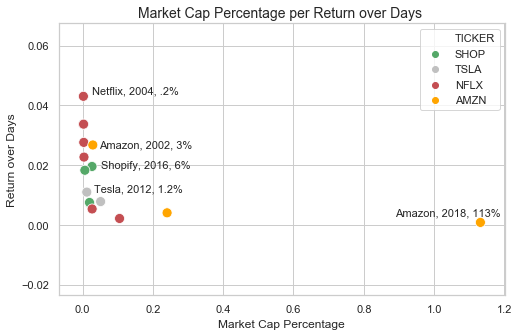

In [130]:
fig, ax = plt.subplots(figsize=(8, 5))
chart = sns.scatterplot(x='MARKET CAP PERCENTAGE', y='Return over Days', hue='TICKER',
                        data=stocks_market_cap, ax=ax, palette=['g', 'silver', 'r', 'orange'], s=100)

ax.text(1.04, .004, "Amazon, 2018, 113%",
        horizontalalignment='center', verticalalignment='center', fontsize=11)
ax.text(0.15, .045, "Netflix, 2004, .2%",
        horizontalalignment='center', verticalalignment='center', fontsize=11)
ax.text(0.18, .027, "Amazon, 2002, 3%",
        horizontalalignment='center', verticalalignment='center', fontsize=11)
ax.text(0.18, .02, "Shopify, 2016, 6%",
        horizontalalignment='center', verticalalignment='center', fontsize=11)
ax.text(0.16, .012, "Tesla, 2012, 1.2%",
        horizontalalignment='center', verticalalignment='center', fontsize=11)

chart.set_title('Market Cap Percentage per Return over Days ', fontsize=14)
chart.set_xlabel('Market Cap Percentage', fontsize=12)
chart.set_ylabel('Return over Days', fontsize=12);

It's pretty clear to have a very high return, your market cap needs to be small. This does seem to be a bayesian trap though. P(high return|small market cap && successful stock) is large but P(successful stock | small market cap) is small.

Amazon at 113% was must because I used yearly largest market cap data at the end of the year. So Amazon at that point in 2018 was larger than Microsoft when the market "tanked" in 2018.

__Lesson 3. Look for small market cap buisness. But look for good businesses too.__

# Question 4: What role does the CEO play in determining a Stock?


Motley Fool says this is the number one identifier of killer companies.

Here, I investigated manually. First I identified stocks that were interesting to me and seemed successful in terms of returns and re-recomendations.
These stocks are:
* Netflix, Amazon, Shopify, Tesla, Zoom, Okta, TDD, Match, Activision, Apple, Nvidia, ZNGA

In [131]:
comp_ceos = pd.DataFrame([
    ['NFLX', 'Reed Hasting', .89, True],
    ['AMZN', 'Jeff Bezos', .86, True],
    ['SHOP', 'Tobias Lütke', .88, True],
    ['TSLA', 'Elon Musk', .71, True],
    ['ZM', 'Eric Yuan', .98, True],
    ['OKTA', 'Todd McKinnon', .96, True],
    ['TDD', 'Jeff Green', .93, True],
    ['MTCH', 'Mandy Ginsberg', .87, False],
    ['ATVI', 'Robert Kotick', .48, False],
    ['AAPL', 'Tim Cook', .92, False],
    ['NVDA', 'Jen-Hsun Huang', .99, True],
    ['ZNGA', 'Frank Gibeau', .95, True]
], columns=['TICKER', 'CEO', 'GLASSDOOR RATING', 'MENTIONED IN REC']).set_index('TICKER')
comp_ceos.sort_values(by=['GLASSDOOR RATING'], ascending=False)

,CEO,GLASSDOOR RATING,MENTIONED IN REC
TICKER,,,
NVDA,Jen-Hsun Huang,0.99,True
ZM,Eric Yuan,0.98,True
OKTA,Todd McKinnon,0.96,True
ZNGA,Frank Gibeau,0.95,True
TDD,Jeff Green,0.93,True
AAPL,Tim Cook,0.92,False
NFLX,Reed Hasting,0.89,True
SHOP,Tobias Lütke,0.88,True
MTCH,Mandy Ginsberg,0.87,False


The leaders of these companies tend to have high ratings and were described as "visionary".

Other notes: It's common these CEOs were immigrants. Another trait is they were successful in other companies (Jen-Hsun Huang, Eric Yuan, Jeff Bezos), creating other companies (Reed Hasting, Elon Musk) or roles before (Tim Cook).

Strong Leadership is important but inconclusive if it's the most important factor. Strong leaders do allow a company to perform over time through good and tough periods.

__Lesson 4. Strong Leaders can drive a company to success.__

# Question 5: What are the Traits of Best Performers?

We can look at our list again.
* Netflix, Amazon, Shopify, Tesla, Zoom, Okta, TDD, Match, Activision, Apple, Nvidia, ZNGA

In [132]:
nflx_explore_yearly = nflx.set_index('Date').asfreq('D').ffill().asfreq('Y')[['Close']]
nflx_explore_yearly = (nflx_explore_yearly / nflx_explore_yearly.shift(1) - 1) * 100
nflx_explore_yearly = nflx_explore_yearly.reset_index()
nflx_explore_yearly['Date'] = nflx_explore_yearly['Date'].apply(lambda x: x.year)
nflx_explore_yearly

,Date,Close
0,2002,NaN
1,2003,396.730029
2,2004,-54.909484
3,2005,119.464651
4,2006,-4.434575
5,2007,2.938890
6,2008,12.284001
7,2009,84.309133
8,2010,218.932656
9,2011,-60.563462


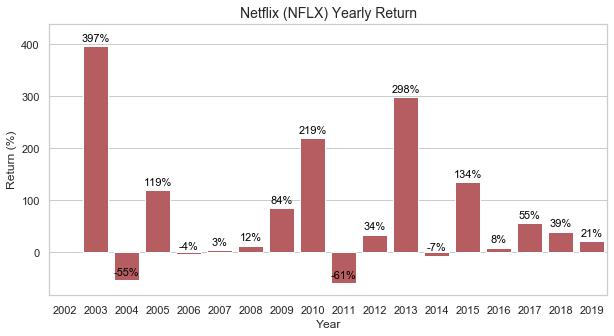

In [133]:
# see distribution of dates. Choose to drop these players.
# We are interested in NCAA stats. Fiiling with mean will make them uncomparable

fig, ax = plt.subplots(figsize=(10, 5))

chart = sns.barplot(x='Date', y='Close', data=nflx_explore_yearly, ax=ax, color='r')

chart.set_ybound(upper=440)
chart.set_title('Netflix (NFLX) Yearly Return', fontsize=14)
#chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_xlabel('Year', fontsize=12)
chart.set_ylabel('Return (%)', fontsize=12)

for p in chart.patches:
    chart.annotate("%.0f" % p.get_height() + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 8),
                textcoords='offset points');

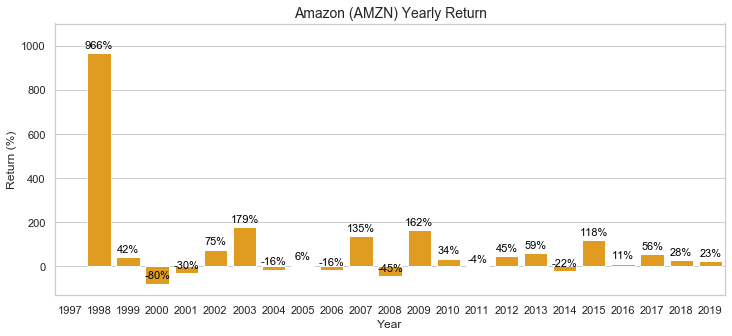

In [134]:
amzn = pd.read_csv('20-06-20_AMZN.csv')
amzn['Date'] = pd.to_datetime(amzn['Date'])

amzn_explore_yearly = amzn.set_index('Date').asfreq('D').ffill().asfreq('Y')[['Close']]
amzn_explore_yearly = (amzn_explore_yearly / amzn_explore_yearly.shift(1) - 1) * 100
amzn_explore_yearly = amzn_explore_yearly.reset_index()
amzn_explore_yearly['Date'] = amzn_explore_yearly['Date'].apply(lambda x: x.year)

# see distribution of dates. Choose to drop these players.
# We are interested in NCAA stats. Fiiling with mean will make them uncomparable

fig, ax = plt.subplots(figsize=(12, 5))

chart = sns.barplot(x='Date', y='Close', data=amzn_explore_yearly, ax=ax, color='orange')

chart.set_ybound(upper=1100)
chart.set_title('Amazon (AMZN) Yearly Return', fontsize=14)
chart.set_xlabel('Year', fontsize=12)
chart.set_ylabel('Return (%)', fontsize=12)

for p in chart.patches:
    chart.annotate("%.0f" % p.get_height() + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 8),
                textcoords='offset points');

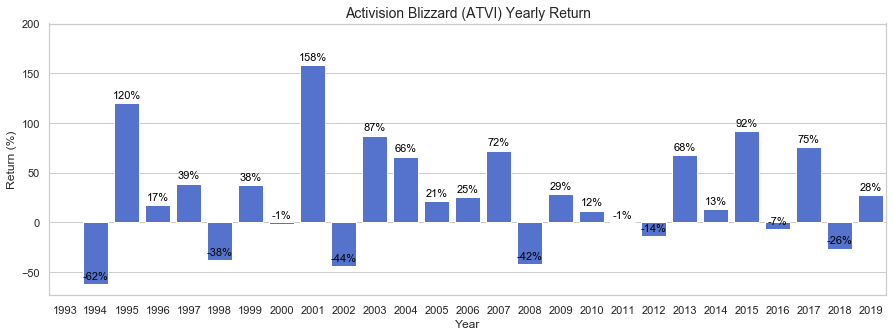

In [135]:
atvi = pd.read_csv('20-06-20_ATVI.csv')
atvi['Date'] = pd.to_datetime(atvi['Date'])

atvi_explore_yearly = atvi.set_index('Date').asfreq('D').ffill().asfreq('Y')[['Close']]
atvi_explore_yearly = (atvi_explore_yearly / atvi_explore_yearly.shift(1) - 1) * 100
atvi_explore_yearly = atvi_explore_yearly.reset_index()
atvi_explore_yearly['Date'] = atvi_explore_yearly['Date'].apply(lambda x: x.year)

fig, ax = plt.subplots(figsize=(15, 5))

chart = sns.barplot(x='Date', y='Close', data=atvi_explore_yearly, ax=ax, color='royalblue')

chart.set_ybound(upper=200)
chart.set_title('Activision Blizzard (ATVI) Yearly Return', fontsize=14)
chart.set_xlabel('Year', fontsize=12)
chart.set_ylabel('Return (%)', fontsize=12)

for p in chart.patches:
    chart.annotate("%.0f" % p.get_height() + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 8),
                textcoords='offset points');

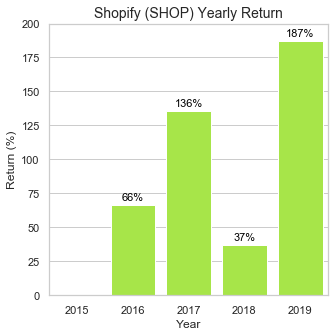

In [136]:
shop = pd.read_csv('20-06-20_SHOP.csv')
shop['Date'] = pd.to_datetime(shop['Date'])

shop_explore_yearly = shop.set_index('Date').asfreq('D').ffill().asfreq('Y')[['Close']]
shop_explore_yearly = (shop_explore_yearly / shop_explore_yearly.shift(1) - 1) * 100
shop_explore_yearly = shop_explore_yearly.reset_index()
shop_explore_yearly['Date'] = shop_explore_yearly['Date'].apply(lambda x: x.year)

fig, ax = plt.subplots(figsize=(5, 5))

chart = sns.barplot(x='Date', y='Close', data=shop_explore_yearly, ax=ax, color='greenyellow')

chart.set_ybound(upper=200)
chart.set_title('Shopify (SHOP) Yearly Return', fontsize=14)
chart.set_xlabel('Year', fontsize=12)
chart.set_ylabel('Return (%)', fontsize=12)

for p in chart.patches:
    chart.annotate("%.0f" % p.get_height() + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 8),
                textcoords='offset points');

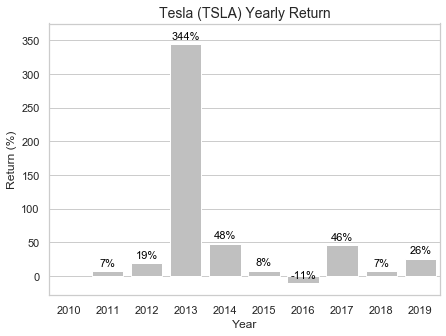

In [137]:
tsla = pd.read_csv('20-06-20_TSLA.csv')
tsla['Date'] = pd.to_datetime(tsla['Date'])

tsla_explore_yearly = tsla.set_index('Date').asfreq('D').ffill().asfreq('Y')[['Close']]
tsla_explore_yearly = (tsla_explore_yearly / tsla_explore_yearly.shift(1) - 1) * 100
tsla_explore_yearly = tsla_explore_yearly.reset_index()
tsla_explore_yearly['Date'] = tsla_explore_yearly['Date'].apply(lambda x: x.year)

fig, ax = plt.subplots(figsize=(7, 5))

chart = sns.barplot(x='Date', y='Close', data=tsla_explore_yearly, ax=ax, color='silver')

chart.set_ybound(upper=375)
chart.set_title('Tesla (TSLA) Yearly Return', fontsize=14)
chart.set_xlabel('Year', fontsize=12)
chart.set_ylabel('Return (%)', fontsize=12)

for p in chart.patches:
    chart.annotate("%.0f" % p.get_height() + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 8),
                textcoords='offset points');

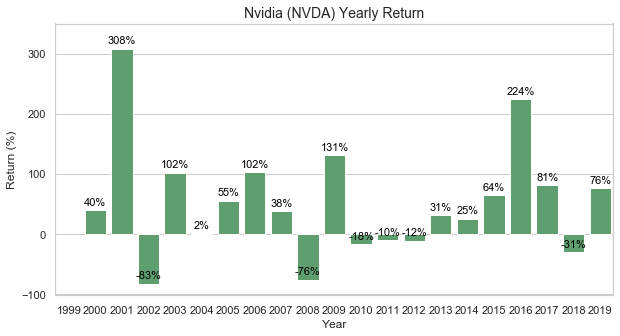

In [138]:
nvda = pd.read_csv('20-06-20_NVDA.csv')
nvda['Date'] = pd.to_datetime(nvda['Date'])

nvda_explore_yearly = nvda.set_index('Date').asfreq('D').ffill().asfreq('Y')[['Close']]
nvda_explore_yearly = (nvda_explore_yearly / nvda_explore_yearly.shift(1) - 1) * 100
nvda_explore_yearly = nvda_explore_yearly.reset_index()
nvda_explore_yearly['Date'] = nvda_explore_yearly['Date'].apply(lambda x: x.year)

fig, ax = plt.subplots(figsize=(10, 5))

chart = sns.barplot(x='Date', y='Close', data=nvda_explore_yearly, ax=ax, color='g')

chart.set_ybound(upper=350)
chart.set_title('Nvidia (NVDA) Yearly Return', fontsize=14)
chart.set_xlabel('Year', fontsize=12)
chart.set_ylabel('Return (%)', fontsize=12)

for p in chart.patches:
    chart.annotate("%.0f" % p.get_height() + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 8),
                textcoords='offset points');

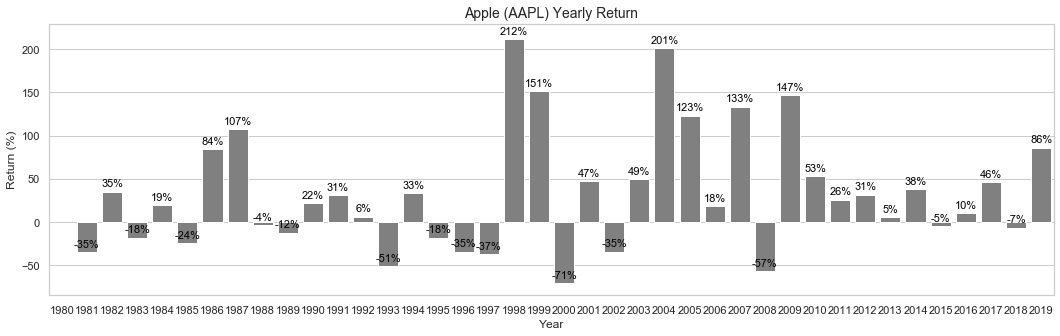

In [149]:
aapl = pd.read_csv('20-06-20_AAPL.csv')
aapl['Date'] = pd.to_datetime(aapl['Date'])

aapl_explore_yearly = aapl.set_index('Date').asfreq('D').ffill().asfreq('Y')[['Close']]
aapl_explore_yearly = (aapl_explore_yearly / aapl_explore_yearly.shift(1) - 1) * 100
aapl_explore_yearly = aapl_explore_yearly.reset_index()
aapl_explore_yearly['Date'] = aapl_explore_yearly['Date'].apply(lambda x: x.year)

fig, ax = plt.subplots(figsize=(18, 5))

chart = sns.barplot(x='Date', y='Close', data=aapl_explore_yearly, ax=ax, color='gray')

chart.set_ybound(upper=230)
chart.set_title('Apple (AAPL) Yearly Return', fontsize=14)
chart.set_xlabel('Year', fontsize=12)
chart.set_ylabel('Return (%)', fontsize=12)

for p in chart.patches:
    chart.annotate("%.0f" % p.get_height() + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 8),
                textcoords='offset points');

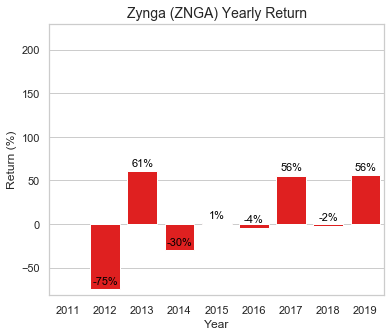

In [152]:
znga = pd.read_csv('20-06-20_ZNGA.csv')
znga['Date'] = pd.to_datetime(znga['Date'])

znga_explore_yearly = znga.set_index('Date').asfreq('D').ffill().asfreq('Y')[['Close']]
znga_explore_yearly = (znga_explore_yearly / znga_explore_yearly.shift(1) - 1) * 100
znga_explore_yearly = znga_explore_yearly.reset_index()
znga_explore_yearly['Date'] = znga_explore_yearly['Date'].apply(lambda x: x.year)

fig, ax = plt.subplots(figsize=(6, 5))

chart = sns.barplot(x='Date', y='Close', data=znga_explore_yearly, ax=ax, color='red')

chart.set_ybound(upper=230)
chart.set_title('Zynga (ZNGA) Yearly Return', fontsize=14)
chart.set_xlabel('Year', fontsize=12)
chart.set_ylabel('Return (%)', fontsize=12)

for p in chart.patches:
    chart.annotate("%.0f" % p.get_height() + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 8),
                textcoords='offset points');

Reading the reports for the companies some things stick out

* Growth - Several of these successful companies were growing at rapid rates, 30-50%, sometime 100%+ a year. They invented new markets and/or were part of new growing markets.
* The Company is Considered Expensive. This could be seen in Apple, Netflix, and Amazon. All of these companies were expensive, had high PE ratios, priced to perfection. Yet they were all able to grow and exceed expectations.
* Unconsidered Potential Factors. In the Apple report, David mentions the potential of the iPhone, even when most of Apple's sales were from Macs and iPods. Early in Netflix, streaming was a considering to their DVD business, and David believedas the market leader, they would be the best to execute on it.
* Strong Leaders - Both brothers show conviction and trust in their leader. Reed Hasting was succesful in his company before Netflix. Elon Musk, Jeff Bezos, Steve Jobs are described as visionary. Tobias Lütke and Eric Yuan are scrappy and convicted to their mission.
* Under-rated by Wall Street - David talks a lot about this. Zynga was believed to be dead by everybody, but has been chugging along. Wall Street doesn't get the business model and potential of Netflix.
* Strong business models. Netflix's subscription business model provided it consistent revenue. Apple subsidised their phones with AT&T plans, and created the App Marketplace with a 30% cut. Tesla created a luxury car brand, then used that to built consumer affordable cars.

__Lesson 5. Successful companies have tremendous consistent growth. Successful companies will seem and be objectively expensive. The companies have strong, convicted, scrappy, visionary leaders that can adapt to competition, build new markets, and provide strong leadership in tough times.__

# Question 6: What could be the next Netflix?

I like the list I've put out
* Netflix, Amazon, Shopify, Tesla, Zoom, Okta, TDD, Match, Activision, Apple, Nvidia, ZNGA

* Netflix. Their leadership is incredible strong and has proven himself time over time again. They have shown to make data driven decisions, bold bets, and adapt to changing markets. They have huge opportunity for growth internationally.
* Amazon. Amazon has proven itself in its strategy to continuously reinvest in itself. It isn't afraid to take bold bets and invest into them, creating huge winners like AWS. Jeff Bezos has shown himself to be visionary and stays true to his 1999 principles of customer obsession, and continuous investment for the future
* Shopfiy. Shopify is defining the online store e-commerce marketplace. One could imagine them as the next Amazon, or even overtake Amazon as Amazon did to eBay in 1999. Tobias is young and scrapy, ready to build the future of e-commerce.
* Tesla. One could imagine this as the Amazon of energy. Electric cars on the road. Solar panels and battery stations everywhere. Advanced robotics and manufacturing. SpaceX, Hyperloop. Even gaining market share in the automobile industry will be highly profitable. Elon Musk is crazy, but dutifully convicted in his mission.
* Zoom. A small video chat app, that has taken the world by storm. It just works. It has mindshare in the public and can leverage that to gain market share in businesses. It can use that to grow consumer products and become the defacto online comunication platform. Eric Yuan is determined, it took him 9 times to get a Visa to come to the US. He will leverage his position to grow Zoom into a successful giant.
* Okta. As businesses go online, cloud security becomes increasingly important. Okta becomes the defacto IAM management for businesses, and holds a high margin SAAS business. Their leadership come from Salesforce and have huge success building SAAS businesses.
* The Trade Desk. Online Ads is a hugely profitable business. The Trade Desk makes to fair for everybody and becomes the defacto marketplace for ads. Jeff Green has been successful in the ad business for a long time. He sold his first ad startup to Microsoft and is hungry and back for more with The Trade Desk.
* Match. Underrated by Wall Street, has a strong high margin ads business. Match can leverage itself as the platform for online dating and grow the market for online dating. They can continuously refine their business plan, targeting demographics, locations, and extra consumer surplus to become a highly lucrative business.
* Activision. Gaming as a Service is a new business model that's highly lucrative and sticky for customers. Activision Blizzard has done a phenomenal job leveraging this with Overwatch and Heartstone. On Twitch, Call of Duty: Modern Warfare is the 2nd most popular game.
* Apple. Apple is in an incredible place in its position. It's new strategy is building the Apple ecosystem, the iPhone, the Macbook, Airpods, iPod. Their products are expensive, but they build high quality products and people continue to buy them. Tim Cook has shown he is able to grow the company and build great products.
* Nvidia. Nvidia will power the future of deep learning and AI. Data center computing is highly lucrative and Nvidia is growing massively in that market. Nvidia holds a monopoly on GPU technology and will continue to become increasingly important in the technology of the future.
* Zynga. Zynga again was underestimated by Wall Street. Mobile Gaming is highly profitable, ads, and most of Facebook's revenue comes from mobile for example. Zynga can continue to grow and as the mobile gaming leader, become a force in the market.